In [252]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
local_base_url = 'http://localhost:2000'

In [253]:
import os
import sys

backend_path = os.path.abspath(os.path.join(os.getcwd(), '../backend'))
sys.path.append(backend_path)

from app.internal.firebase import db

In [125]:
exchange_token = "100"
smallcase_name = "Amara Raja Energy & Mobility Ltd"

start_date = "2023-12-15"
end_date = "2024-03-14"

q = await db.collection("tickers").where("smallcase_name", "==", smallcase_name).get()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:290: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/google/api_core/retry/retry_unary.py:146: UserWarning: Using the synchronous google.api_core.retry.Retry with asynchronous calls may lead to unexpected results. Please use google.api_core.retry_async.AsyncRetry instead.
  warnings.warn(_ASYNC_RETRY_WARNING)


In [126]:
if q:
    equity = q[0].to_dict()
    resp = requests.get(f"{local_base_url}/tickers/{equity['exchange_token']}/candles?start_date={start_date}&end_date={end_date}")
    print(resp.status_code)

200


In [127]:
candles: dict = resp.json()

In [128]:
df_train = pd.DataFrame.from_dict(candles, orient="index")
df_train.index.name = "date"
df_train.head()

,open,high,low,close,volume,open_interest
date,,,,,,
2023-12-15,774.50,779.90,763.05,765.25,352696,0
2023-12-18,768.90,789.45,757.15,781.25,965918,0
2023-12-19,789.95,799.60,778.25,781.95,846627,0
2023-12-20,784.00,786.50,737.80,743.80,935363,0
2023-12-21,731.55,765.25,728.50,762.45,661832,0


In [129]:
df_train.to_csv("candles.csv")

In [130]:
import math
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [131]:
dates = list(candles.keys())
n = len(dates)

returns = []
for i in range(n - 1):
    prev_price = candles[dates[i]]["close"]
    next_price = candles[dates[i + 1]]["close"]
    r = math.log(prev_price / next_price)
    returns.append(r)

s = sum(returns)
n -= 1 # Adjusting for the last data point
mean = s / n
print("Mean:", mean)

q = 0
for r in returns:
    q += (r - mean) ** 2

print("Sum of squared deviations:", q)
print("Variance:", q / n)

variance = np.var(returns)
print("Variance:", variance)
print("SD:", variance ** 0.5)

print(s, n, s/n)



Mean: -0.0006940839300399
Sum of squared deviations: 0.02625307663087031
Variance: 0.0004234367198527469
Variance: 0.00042343671985274703
SD: 0.02057757808520592
-0.0430332036624738 62 -0.0006940839300399


### Backtesting

In [132]:
DATE_FORMAT = "%Y-%m-%d"
smallcase_id = "SCAW_0001"
quarter_end = "2019-01-01"
params = {"date": quarter_end}

smallcase = requests.get(f"{local_base_url}/smallcases/{smallcase_id}").json()
constituents = requests.get(f"{local_base_url}/smallcases/{smallcase_id}/constituents", params=params).json()

start_date = constituents["start_date"]
end_date = constituents["end_date"]

# prev_start_date = datetime.strptime(start_date, DATE_FORMAT) - relativedelta(months=3)
# prev_start_date = prev_start_date.strftime(DATE_FORMAT)

# prev_end_date = datetime.strptime(end_date, DATE_FORMAT) - relativedelta(months=3)
# prev_end_date = prev_end_date.strftime(DATE_FORMAT)

In [133]:
async def get_candles_from_smallcase_name(smallcase_name: str, start_date, end_date):
    q = await db.collection("tickers").where("smallcase_name", "==", smallcase_name).get()
    if q:
        equity = q[0].to_dict()
        resp = requests.get(f"{local_base_url}/tickers/{equity['exchange_token']}/candles?start_date={start_date}&end_date={end_date}")
        if resp.status_code == 200:
            return resp.json()
        print(resp.status_code, "Not Found")

In [134]:
async def get_candles(constituents, start_date, end_date):
    candles = {}
    for c in constituents:
        # Maybe BE can have a call for this
        ticker = await db.collection("tickers").where("smallcase_name", "==", c["smallcase_name"]).get()
        if ticker:
            ticker = ticker[0].to_dict()
            params = {"start_date": start_date, "end_date": end_date}
            resp = requests.get(f"{local_base_url}/tickers/{ticker['exchange_token']}/candles", params=params)
            candles[c["smallcase_name"]] = resp.json()

    return candles

In [135]:
c = constituents["constituents"]
candles = await get_candles(c, start_date, end_date)
len(candles) == len(c)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/google/cloud/firestore_v1/base_collection.py:290: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)
/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/google/api_core/retry/retry_unary.py:146: UserWarning: Using the synchronous google.api_core.retry.Retry with asynchronous calls may lead to unexpected results. Please use google.api_core.retry_async.AsyncRetry instead.
  warnings.warn(_ASYNC_RETRY_WARNING)


True

In [136]:
candles_at_inception = {}
inception_date = "2018-07-18"

for constituent in c:
    ticker = await db.collection("tickers").where("smallcase_name", "==", constituent["smallcase_name"]).get()
    if ticker:
        ticker = ticker[0].to_dict()
        resp = requests.get(f"{local_base_url}/tickers/{ticker['exchange_token']}/candles/{inception_date}")
        candles_at_inception[constituent["smallcase_name"]] = resp.json()

len(candles_at_inception) == len(c)

True

In [137]:
def calculate_index(constituents: list, inception_date: str, date: str) -> int:
    index = 100
    indexes = 0
    for c in constituents:
        try:
            name = c["smallcase_name"]
            weight = c["original_weightage"]

            close = candles[name][date]["close"]
            close_at_inception = candles_at_inception[name]["daily"][inception_date]["close"]

            investable_shares = (index * weight) / close_at_inception
            indexes += investable_shares * close
            
        except KeyError as e:
            print(e)
            print(f"Candle not found for {name}. Skipping index on {date}.")
            continue
    return indexes


In [138]:
indexes = calculate_index(c, inception_date, "2019-03-27")
indexes

103.66443091913047

## Expected Value

In [151]:
import requests
import numpy as np
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

BASE_URL = "http://localhost:7999"

In [169]:
smallcase_name = "Nippon India ETF Nifty Next 50 Junior BeES"
exchange_token = "10939"
quarter_end = "2023-09-30"
quarter_start = "2023-07-01"


quarter_prev = (pd.to_datetime(quarter_start) - pd.DateOffset(years=1)).strftime("%Y-%m-%d")

params = {"start_date": quarter_prev , "end_date": quarter_start}
train_candles = requests.get(f"{BASE_URL}/tickers/{exchange_token}/candles", params=params).json()
test_candles = []
test_candles = requests.get(f"{BASE_URL}/tickers/{exchange_token}/candles", params={"start_date": quarter_start, "end_date": quarter_end}).json()
len(train_candles), len(test_candles)

(247, 63)

In [170]:
df_train = pd.DataFrame.from_dict(train_candles, orient="index")
df_train.index = pd.to_datetime(df_train.index)
df_test = pd.DataFrame.from_dict(test_candles, orient="index")
df_test.index = pd.to_datetime(df_test.index)

df_close = df_train["close"].to_frame()
df_close.head()

df_train.head()

,open,high,low,close,volume,open_interest
2022-07-01,397.40,397.40,380.00,390.18,96987,0
2022-07-04,399.99,399.99,386.18,392.64,393177,0
2022-07-05,397.96,397.96,385.25,393.98,161099,0
2022-07-06,398.00,400.34,386.25,399.68,110619,0
2022-07-07,413.99,413.99,391.26,404.42,146163,0


In [171]:
m = 4 # Quarterly data
model = auto_arima(df_close, seasonal=True, m=m)
best_order = model.get_params()["order"]
best_seasonal_order = model.get_params()["seasonal_order"]
best_order, best_seasonal_order

((1, 1, 0), (1, 0, 1, 4))

In [172]:
def get_expected_value(candles: list):
    model = ARIMA(candles, order=best_order)
    model_fit = model.fit()    
    expected_value = model_fit.forecast()
    return expected_value[0]

In [173]:
temp = df_close["close"].values
train_split = int(0.6 * len(temp)) # 60-40 split
train, test = temp[:train_split], temp[train_split:]


historical_candles = [c for c in train]
expected_values = []
for candle in test:
    expected_values.append(get_expected_value(historical_candles))
    historical_candles.append(candle)


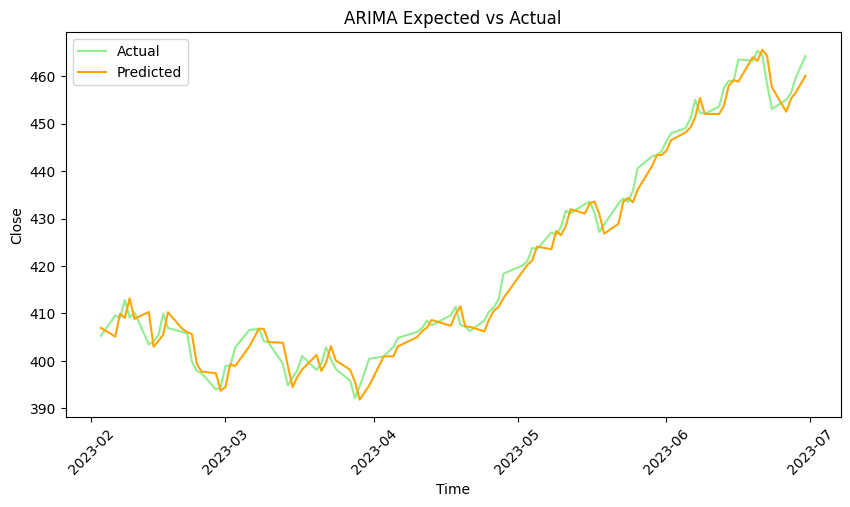

In [184]:
plt.figure(figsize=(10, 5))
plt.title("ARIMA Expected vs Actual")
plt.xlabel("Time")
plt.ylabel("Close")
plt.xticks(rotation=45)
plt.plot(df_close.iloc[train_split:].index, test, label="Actual", color="lightgreen")
plt.plot(df_close.iloc[train_split:].index, expected_values, label="Predicted", color="orange")
plt.legend()
plt.show()

In [175]:
mae = mean_absolute_error(test, expected_values)
mse = mean_squared_error(test, expected_values)

adjusted_mae = (mae / np.mean(test)) * 100
adjusted_mse = (mse / np.mean(test)) * 100

print(f"Adjusted MAE: {adjusted_mae} %, Adjusted MSE: {adjusted_mse} %")

Adjusted MAE: 0.5353229977515007 %, Adjusted MSE: 1.7869804033481533 %


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


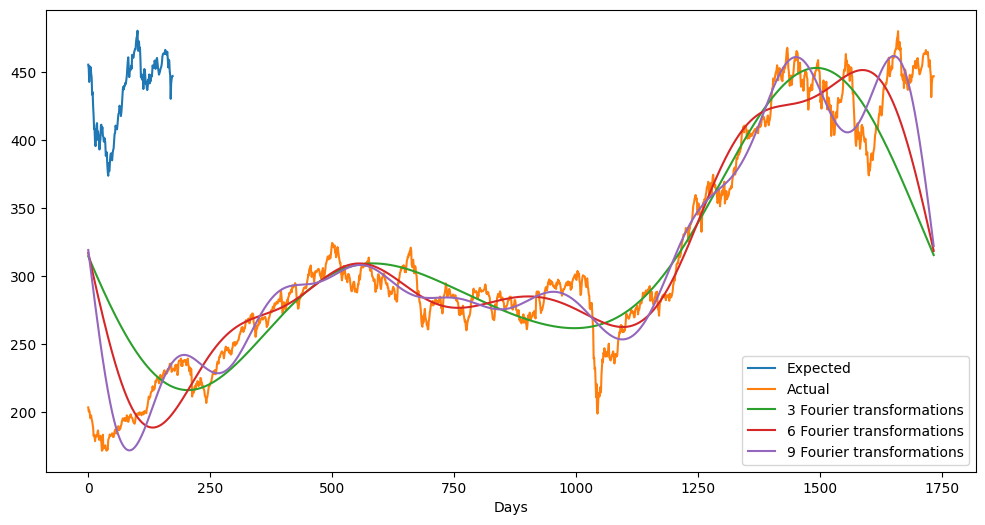

In [386]:
close_prices = df_close[['close'][:len(expected_values)]]
close_prices_array = close_prices['close'].values.tolist()
fourier_close = np.fft.fft(np.asarray(close_prices['close'].tolist()))
df_fourier = pd.DataFrame({'fourier':fourier_close})
df_fourier['absolute'] = df_fourier['fourier'].apply(lambda x: np.abs(x))
df_fourier['angle'] = df_fourier['fourier'].apply(lambda x: np.angle(x))

plt.figure(figsize=(12, 6))
plt.plot(expected_values, label='Expected')
plt.plot(close_prices_array,  label='Actual')
for num_ in [3, 6, 9]:
    fourier_list= np.copy(fourier_close); fourier_list[num_:-num_]=0
    plt.plot(np.fft.ifft(fourier_list), label='{} Fourier transformations'.format(num_))
plt.xlabel('Days')
plt.legend()
plt.show()

### Test using quarterly returns instead of expected price

In [387]:
returns_train = df_train["close"].resample('Q').ffill().pct_change().dropna()

df_prev_quarter = df_train[df_train.index.max() - pd.DateOffset(months=3):]
df_quarter_on_quarter = pd.concat([df_prev_quarter, df_test])
returns_test = df_quarter_on_quarter["close"].resample('Q').ffill().pct_change().dropna()


len(returns_train), len(returns_test)

/var/folders/lq/280gf8ld14v161g6ngpdjjnc0000gn/T/ipykernel_54121/2804306443.py:1: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  returns_train = df_train["close"].resample('Q').ffill().pct_change().dropna()
/var/folders/lq/280gf8ld14v161g6ngpdjjnc0000gn/T/ipykernel_54121/2804306443.py:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  returns_test = df_quarter_on_quarter["close"].resample('Q').ffill().pct_change().dropna()


(27, 2)

In [388]:
model = auto_arima(returns_train, m=4, seasonal=True)
best_order = model.get_params()["order"]
best_seasonal_order = model.get_params()["seasonal_order"]
best_order, best_seasonal_order

((0, 0, 0), (0, 0, 0, 4))

In [400]:
def get_expected_value(candles: list):
    model = ARIMA(candles, order=(3, 1, 3))
    model_fit = model.fit()    
    expected_value = model_fit.forecast()
    return expected_value[0]

In [405]:
model = ARIMA(returns_train, order=best_order)
model_fit = model.fit()
forecast = model_fit.forecast(1, alpha=0.05)
forecast, returns_test

/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


(2023-03-31    0.037834
 Freq: QE-DEC, dtype: float64,
 2022-12-31   -0.001161
 2023-03-31   -0.104644
 Freq: QE-DEC, Name: close, dtype: float64)

In [406]:
temp = returns_train.values
train_split = int(0.6 * len(temp))
train, test = temp[:train_split], temp[train_split:]

histotical_returns = [r for r in train]
expected_values = []
for r in test:
    expected_values.append(get_expected_value(histotical_returns))
    histotical_returns.append(r)

/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/aaryanpagar/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimi

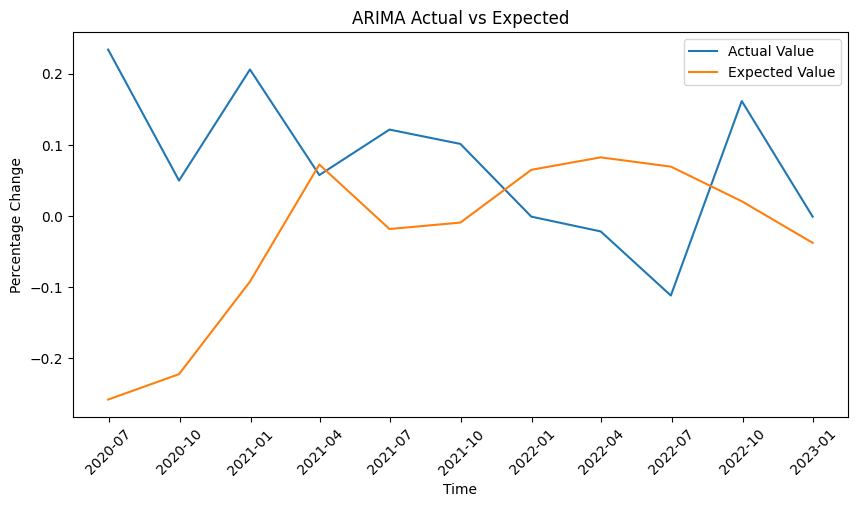

In [407]:
plt.figure(figsize=(10, 5))
plt.title("ARIMA Actual vs Expected")
plt.xlabel("Time")
plt.ylabel("Percentage Change")
plt.xticks(rotation=45)
plt.plot(returns_train.iloc[train_split:].index, test, label="Actual Value")
plt.plot(returns_train.iloc[train_split:].index, expected_values, label="Expected Value")
plt.legend()
plt.show()

### ARIMA stuff again

In [ ]:
def get_arima_candles_df(candles):
    temp = candles["close"].values
    train_split = int(0.7 * len(temp)) # 70-30 split
    train, test = temp[:train_split], temp[train_split:]
    historical_candles = [c for c in train]
    expected_values = []

    m = 4
    model_params = auto_arima(temp, seasonal=True, m=m)
    best_order = model_params.get_params()["order"]
    model = ARIMA(historical_candles, order=best_order)
    model_fitted = model.fit()

    for candle in test:
        expected_value = model_fitted.forecast()
        model_fitted = model_fitted.extend(historical_candles)

        expected_values.append(expected_value[0])
        historical_candles.append(candle)

    return expected_values

## Fresh

In [48]:
import requests
import numpy as np
import pandas as pd
from pandas import DataFrame as DF
import matplotlib.pyplot as plt

from datetime import datetime
from dateutil.relativedelta import relativedelta

DATE_FORMAT = "%Y-%m-%d"
local_base_url = 'http://localhost:7999'

In [49]:
class TickerNotFound(Exception):
    pass

In [86]:
def get_candles_df(smallcase_name: str, start_date: str, end_date: str) -> tuple[DF, DF]:
    try:
        ticker = requests.get(f"{local_base_url}/tickers", params={"smallcase_name": smallcase_name}).json()
        exchange_token = ticker["exchange_token"]
    except KeyError as e:
        print(ticker, e)
        raise TickerNotFound()
    
    params = {"start_date": start_date, "end_date": end_date}
    resp = requests.get(f"{local_base_url}/tickers/{exchange_token}/candles", params=params)
    candles = resp.json()
    df = pd.DataFrame.from_dict(candles, orient="index")
    df.index = pd.to_datetime(df.index)
    df_close = df["close"].to_frame()
    return df, df_close

In [51]:
def get_indexes_df(smallcase_id: str, start_date: str, end_date: str) -> DF:
    params = {"start_date": start_date, "end_date": end_date}
    indexes = requests.get(f"{local_base_url}/smallcases/{smallcase_id}/indexes", params=params).json()

    df = pd.DataFrame.from_dict(indexes, orient="index")
    df.index = pd.to_datetime(df.index)
    return df

In [52]:
def get_variance(candles: DF):
    candles = candles.sort_index()
    returns = candles["close"].pct_change().dropna()
    return np.var(returns)

In [76]:
def get_expected_returns(candles: DF, indexes: DF):
    candles["smallcase_returns"] = candles["close"].pct_change()
    # return np.mean(candles["smallcase_returns"])
    candles["benchmark_returns"] = indexes["benchmark"].pct_change()
    candles = candles.dropna()

    covariance = np.cov(candles["smallcase_returns"], candles["benchmark_returns"])[0, 1]
    market_variance = np.var(candles["benchmark_returns"])
    beta = covariance / market_variance

    risk_free_rate = 0.068
    expected_market_return = 0.123

    expected_return = risk_free_rate + beta * (expected_market_return - risk_free_rate)
    return expected_return / 247

In [77]:
def get_kelly_weightage(expected_return: float, variance: float):
    annual_risk_free_rate = 0.068
    adjusted_risk_free_rate = (1 + annual_risk_free_rate)**(1/247) - 1
    
    kelly_weightage = (expected_return - adjusted_risk_free_rate) / variance
    return kelly_weightage
  

In [78]:
def get_adjusted_kelly_constituents(constituents: list):
    total_kelly_weight = sum(float(c["half_kelly_weightage"]) for c in constituents)
    for c in constituents:
         c["adjusted_kelly_weightage"] = "{:,.6f}".format((float(c["half_kelly_weightage"]) / total_kelly_weight))
    return constituents


In [56]:
ids = [
    {"id": "SCAW_0001", "name": "All Weather Investing"},
    {"id": "SCMO_0015", "name": "Safe Haven"},
    {"id": "SCMO_0026", "name": "Growth & Income"},
    {"id": "SCMO_0016", "name": "The Naked Trader"},
    {"id": "SCMO_0024", "name": "The PE List"},
    {"id": "SCMO_0013", "name": "Dividend Stars"},
    {"id": "SCMO_0014", "name": "Dividend Aristocrats"},
    {"id": "SCNM_0025", "name": "Electric Mobility"},
    {"id": "SCNM_0012", "name": "Rising Rural Demand"},
    {"id": "SCTR_0014", "name": "House of Tata"},
    {"id": "SCTR_0017", "name": "House of Murugappa"},
    {"id": "SCTR_0010", "name": "Realty Tracker"},
]
scid = ids[4]["id"]
scid

'SCMO_0024'

In [58]:
constituents = requests.get(f"{local_base_url}/smallcases/{scid}/constituents/stream").json()
len(constituents)

8

In [79]:

failed = []
ticker_not_found = 0

# Skip the first 2 quarters
for quarter in constituents[2:3]:
    # T - 2 quarters
    end_date = quarter["start_date"]
    start_date = datetime.strptime(end_date, DATE_FORMAT)
    start_date = start_date - relativedelta(months=6)
    start_date = start_date.strftime(DATE_FORMAT)
    print(f"Date range: {start_date} to {end_date}")

    df_indexes = get_indexes_df(scid, start_date, end_date)
    df_indexes["benchmark"].to_frame()

    kelly_constituents = []
    for constituent in quarter["constituents"]:
        smallcase_name = constituent["smallcase_name"]
        print(f"Calculating {smallcase_name}...")
        try:
            df, df_close = get_candles_df(smallcase_name, start_date, end_date)
            variance = get_variance(df_close)
            expected_returns = get_expected_returns(df_close, df_indexes)
            kelly = get_kelly_weightage(expected_returns, variance)
        except TickerNotFound:
            print("Ticker not found, using same kelly weightage")
            ticker_not_found += 1
            kelly = constituent["original_weightage"]
          
        kelly_constituent = {**constituent}
        kelly_constituent["kelly_weightage"] = "{:,.6f}".format(kelly)
        kelly_constituent["half_kelly_weightage"] = "{:,.6f}".format(kelly * 0.5)
        kelly_constituent["standard_deviation"] = "{:,.6f}".format(np.sqrt(variance))
        kelly_constituents.append(kelly_constituent)

    kelly_payload = {**quarter}
    adjusted_kelly_constituents = get_adjusted_kelly_constituents(kelly_constituents)
    kelly_payload["constituents"] = adjusted_kelly_constituents
    print(kelly_payload)

    resp = requests.post(f"{local_base_url}/smallcases/{scid}/constituents", json=kelly_payload)    
    if resp.status_code not in [200, 201]:
        print(resp.json())
        failed.append(quarter)

print(f"Failed {len(failed)}")

Date range: 2017-11-30 to 2018-05-31
Calculating Capfin India Ltd...
{'detail': 'Ticker not found'} 'exchange_token'
Ticker not found, using same kelly weightage
Calculating Himadri Speciality Chemical Ltd...
Calculating Zensar Technologies Ltd...
Calculating Prabhat Dairy Ltd...
{'detail': 'Ticker not found'} 'exchange_token'
Ticker not found, using same kelly weightage
Calculating MindTree Ltd...
{'detail': 'Ticker not found'} 'exchange_token'
Ticker not found, using same kelly weightage
Calculating NRB Bearings Ltd...
Calculating Capacite Infraprojects Ltd...
Calculating Manappuram Finance Ltd...
Calculating Parag Milk Foods Ltd...
Calculating Great Eastern Shipping Company Ltd...
{'start_date': '2018-05-31', 'end_date': '2019-06-16', 'constituents': [{'smallcase_name': 'Capfin India Ltd', 'original_weightage': 0.1, 'kelly_weightage': '0.100000', 'half_kelly_weightage': '0.050000', 'adjusted_kelly_weightage': '0.038716', 'standard_deviation': '0.019131'}, {'smallcase_name': 'Himadri

### Small Kelly Test

In [18]:
df_close["smallcase_returns"] = df_close["close"].pct_change()
df_close = df_close.dropna()
df_close.head()

,close,smallcase_returns
2016-06-02,353.25,0.008134
2016-06-03,355.15,0.005379
2016-06-06,352.20,-0.008306
2016-06-07,355.35,0.008944
2016-06-08,355.65,0.000844


In [19]:
positive = df_close.where(df_close["smallcase_returns"] > 0).dropna()
negative = df_close.where(df_close["smallcase_returns"] < 0).dropna()

w = len(positive) / len(df_close)
wlr = positive["smallcase_returns"].mean() / abs(negative["smallcase_returns"].mean())
kelly = w - (1 - w) / wlr
kelly

-0.13454909494510892

## Backtesting

In [87]:


for quarter in constituents[2:3]:

    end_date = quarter["end_date"]
    start_date = quarter["start_date"]
    print(f"Date Range: {start_date} - {end_date}")
    df_indexes = get_indexes_df(scid, start_date, end_date)

    candles = []
    for constituent in quarter["constituents"][1:2]:
        name = constituent["smallcase_name"]
        print(f"Calculating index for {name}...")
        try:
            df, df_close = get_candles_df(constituent["smallcase_name"], start_date, end_date)
        except TickerNotFound:
            print("Ticker not found, using same kelly weightage")
            candles.append({"constituent": constituent["smallcase_name"], "candles": df_close})

    print(candles)
        

Date Range: 2018-05-31 - 2019-06-16
Calculating index for Himadri Speciality Chemical Ltd...
{'detail': 'Cannot fetch data for more than 1 year(s)'}


DateParseError: Unknown datetime string format, unable to parse: detail, at position 0